In [1]:
#download dataset
!wget --no-check-certificate \
http://fahmifuady.site/wp-content/uploads/2020/09/dataset_sms_v3.zip \
-O dataset_sms_v3.zip

# ekstrak file zip
import os
import zipfile

fzip = '/content/dataset_sms_v3.zip'
ekstrak = zipfile.ZipFile(fzip, 'r')
ekstrak.extractall('/content')


--2020-09-07 08:25:52--  http://fahmifuady.site/wp-content/uploads/2020/09/dataset_sms_v3.zip
Resolving fahmifuady.site (fahmifuady.site)... 165.22.55.67
Connecting to fahmifuady.site (fahmifuady.site)|165.22.55.67|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://fahmifuady.site/wp-content/uploads/2020/09/dataset_sms_v3.zip [following]
--2020-09-07 08:25:54--  https://fahmifuady.site/wp-content/uploads/2020/09/dataset_sms_v3.zip
Connecting to fahmifuady.site (fahmifuady.site)|165.22.55.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106233 (104K) [application/zip]
Saving to: ‘dataset_sms_v3.zip’

dataset_sms_v3.zip  100%[===================>] 103.74K   167KB/s    in 0.6s    

2020-09-07 08:25:56 (167 KB/s) - ‘dataset_sms_v3.zip’ saved [106233/106233]



In [2]:
import pandas as pd
df = pd.read_csv('dataset_sms_v3.zip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2286 entries, 0 to 2285
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    2286 non-null   object
 1   label   2286 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.8+ KB


In [3]:
df.head

<bound method NDFrame.head of                                                    Teks  label
0     [PROMO] Beli paket Flash mulai 1GB di MY TELKO...      2
1     2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...      2
2     2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...      2
3     2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...      2
4     4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...      2
...                                                 ...    ...
2281     Yooo sama2, oke nanti aku umumin di grup kelas      0
2282  😁 sebelumnya ga ad nulis kerudung. Kirain warn...      0
2283                               Mba mau kirim 300 ya      0
2284  nama1  beaok bwrangkat pagi...mau cas atay tra...      0
2285                         No bri atas nama kamu mana      0

[2286 rows x 2 columns]>

In [ ]:
# melakukan one-hot-encoding dan membuat dataset baru
category = pd.get_dummies(df.label)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='label')
df_baru

#Penjelasan Label 
#0: sms normal (1138)
#1: sms spam (670)
#2: promo (478)
#total = 1138 + 670 + 478 = 2286

In [5]:
df_baru.columns

Index(['Teks', 0, 1, 2], dtype='object')

In [6]:
# ubah dari dataframe jadi numpy array
isisms = df_baru['Teks'].values
label = df_baru[[0, 1, 2]].values

#train test split
from sklearn.model_selection import train_test_split
sms_train, sms_test, label_train, label_test = train_test_split(isisms, label, test_size=0.2)

#fungsi tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(sms_train) 
tokenizer.fit_on_texts(sms_test)

seq_train = tokenizer.texts_to_sequences(sms_train)
seq_test  = tokenizer.texts_to_sequences(sms_test)

pad_train = pad_sequences(seq_train)
pad_test  = pad_sequences(seq_test)

In [7]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=6000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          96000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 133,507
Trainable params: 133,507
Non-trainable params: 0
_________________________________________________________________


In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()


num_epoch = 30
history = model.fit(pad_train, label_train, epochs=num_epoch,
                    validation_data=(pad_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
58/58 - 1s - loss: 0.8752 - accuracy: 0.5875 - val_loss: 0.6364 - val_accuracy: 0.7009
Epoch 2/30
58/58 - 0s - loss: 0.3759 - accuracy: 0.8156 - val_loss: 0.2113 - val_accuracy: 0.9410
Epoch 3/30

Akurasi telah mencapai >90%!
58/58 - 0s - loss: 0.0772 - accuracy: 0.9787 - val_loss: 0.0994 - val_accuracy: 0.9629


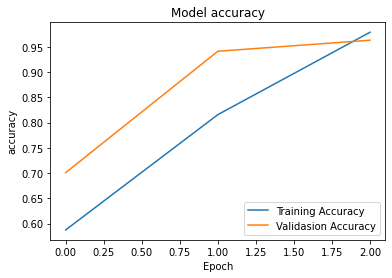

In [13]:
# liat grafik
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validasion Accuracy')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()